# CarND Object Detection Lab

Let's get started!

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
import time
from scipy.stats import norm

%matplotlib inline
plt.style.use('ggplot')

## Prepare dataset for training and validation

In [47]:
import csv
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

In [135]:
"""# Read in info about raw data from car camera and safe in df (pd.DataFrame format)
with open('images/images/classes.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    content = list()
    for row in spamreader:
        #print(', '.join(row))
        row[0] = 'images/images/'+row[0]
        content.append(row)

with open('images/images2/classes.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        #print(', '.join(row))
        row[0] = 'images/images2/'+row[0]
        content.append(row)
#df = pd.DataFrame(data=content, columns=["path", "class"])
#df["class"].value_counts(),df.describe()
content = np.array(content)"""

In [140]:
content = list()
with open('images/signlabels.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        content.append(row)
content = np.array(content)

In [114]:
def load_content(content):
    images = list()
    labels = list()
    for path, label in content:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        if label == "green":
            labels.append(2)
        elif label == "red":
            labels.append(0)
        elif label == "yellow":
            labels.append(1)
        else:
            labels.append(4)
            print("[ERROR] Label of image ", path, " neither red, yellow, or green!")
    images = np.asarray(images)
    labels = np.asarray(labels)
    return images, labels


images, labels = load_content(content)
print(images.shape, images.dtype)
print(labels.shape, labels.dtype)

(293, 600, 800, 3) uint8
(293,) int32


In [98]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

## Object Detection Inference

In this part of the lab you'll detect objects using pretrained object detection models. You can download the latest pretrained models from the [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md), although do note that you may need a newer version of TensorFlow (such as v1.8) in order to use the newest models.

We are providing the download links for the below noted files to ensure compatibility between the included environment file and the models.

[SSD_Mobilenet 11.6.17 version](http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz)

[RFCN_ResNet101 11.6.17 version](http://download.tensorflow.org/models/object_detection/rfcn_resnet101_coco_11_06_2017.tar.gz)

[Faster_RCNN_Inception_ResNet 11.6.17 version](http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017.tar.gz)

Make sure to extract these files prior to continuing!

In [12]:
# Frozen inference graph files. NOTE: change the path to where you saved the models.
SSD_GRAPH_FILE = 'models/ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb'
RFCN_GRAPH_FILE = 'models/rfcn_resnet101_coco_11_06_2017/frozen_inference_graph.pb'
FASTER_RCNN_GRAPH_FILE = 'models/faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017/frozen_inference_graph.pb'
FASTER_RCNN_KITTI_FILE = 'models/faster_rcnn_resnet101_kitti_2018_01_28/frozen_inference_graph.pb'
SSDLITE_GRAPH_FILE = 'models/ssdlite_mobilenet_v2_coco_2018_05_09/frozen_inference_graph.pb'

Below are utility functions. The main purpose of these is to draw the bounding boxes back onto the original image.

In [30]:
# Colors (one for each class)
cmap = ImageColor.colormap
print("Number of colors =", len(cmap))
COLOR_LIST = sorted([c for c in cmap.keys()])

#
# Utility funcs
#

def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def filter_boxes1(min_score, search_class, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score and classes[i] == search_class:
            idxs.append(i)
            break
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image_path, boxes, classes, thickness=4):
    """Draw bounding boxes on the image"""
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = COLOR_LIST[class_id]
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)
        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

Number of colors = 148


In [41]:
def detect_tl(image, sess):
    image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    classer.append(classes)
    scorer.append(scores)

    confidence_cutoff = 0.45
    search_class = 10
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes1(confidence_cutoff, search_class, boxes, scores, classes)


    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.shape[1], image.shape[0]
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(path, box_coords, classes)

    # Crop image to detected traffic light
    coords = np.squeeze(box_coords).astype(int)
    return coords

Below we load the graph and extract the relevant tensors using [`get_tensor_by_name`](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name). These tensors reflect the input and outputs of the graph, or least the ones we care about for detecting objects.

In [207]:
#detection_graph = load_graph(SSD_GRAPH_FILE)
# detection_graph = load_graph(RFCN_GRAPH_FILE)
# detection_graph = load_graph(FASTER_RCNN_GRAPH_FILE)
detection_graph = load_graph(SSDLITE_GRAPH_FILE)

# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

Run detection and classification on a sample image.

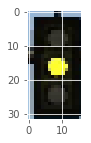

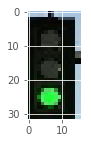

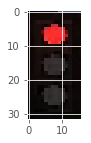

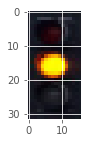

In [43]:
# Load a sample image.

image1 = './images/images/frame0140.jpg'
image2 = './images/images/frame0116.jpg'
image3 = './images/images/frame0000.jpg'
#image4 = './images/frame0092.jpg'
image4 = './images/image001.jpg'
images = [image1, image2, image3, image4]

with tf.Session(graph=detection_graph) as sess:                
    # Actual detection.
    for path in images:
        img = cv2.imread(path)
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Detect traffic light in image
        coords = detect_tl(image, sess)
        
        # Show detected traffic light only
        image1 = cv2.resize(image[coords[0]:coords[2], coords[1]:coords[3]], (16,32))
        plt.figure(figsize=(2, 2))
        plt.imshow(image1)
        
        # Show complete image with annotated boxes
        #plt.figure(figsize=(6,4))
        #plt.imshow(image)

## Make training data for classifier

In [151]:
new_content = list()
error_counter = 0
total_counter = 0
with tf.Session(graph=detection_graph) as sess:                
    for path, label in content:
        img = cv2.imread(path)
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Detect traffic light in image
        coords = detect_tl(image)
        
        # Show detected traffic light only
        try:
            image1 = cv2.resize(image[coords[0]:coords[2], coords[1]:coords[3]], (16,32))

            # Saving the image 
            filename = path[:path.find(".jpg")]+"_sign_only.jpg"
            image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
            cv2.imwrite(filename, image1)
            new_content.append([filename, label])
        except:
            print("[Error] Detector could not find a sign in image ", path)
            error_counter +=1
        total_counter +=1
        
print("TL_Detector did not detect ", error_counter, " of ", total_counter, " images -> ",
      np.around(100*error_counter/total_counter, decimals=1), " %")

# Save info in seperate file
with open('images/signlabels_sign_only.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='|')
    spamwriter.writerows(new_content)

[Error] Detector could not find a sign in image  images/images/frame0023.jpg
[Error] Detector could not find a sign in image  images/images/frame0024.jpg
[Error] Detector could not find a sign in image  images/images/frame0025.jpg
[Error] Detector could not find a sign in image  images/images/frame0028.jpg
[Error] Detector could not find a sign in image  images/images/frame0049.jpg
[Error] Detector could not find a sign in image  images/images2/frame0133.jpg
[Error] Detector could not find a sign in image  images/images2/frame0135.jpg
[Error] Detector could not find a sign in image  images/images2/frame0139.jpg
[Error] Detector could not find a sign in image  images/images2/frame0149.jpg
[Error] Detector could not find a sign in image  images/images2/frame0150.jpg
[Error] Detector could not find a sign in image  images/images2/frame0151.jpg
[Error] Detector could not find a sign in image  images/images2/frame0152.jpg
[Error] Detector could not find a sign in image  images/images2/frame

In [153]:
# Load images with signs only for training
images, labels = load_content(new_content)

print(images.shape, images.dtype)
print(labels.shape, labels.dtype)

(243, 32, 16, 3) uint8
(243,) int32


# Build tl_Classifier model

In [173]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.core import Activation
from keras.optimizers import adam
from keras.utils.data_utils import Sequence
from keras.utils import plot_model, to_categorical

In [174]:
# ================================================================================
# standard CNN model
def build_model():
    '''
    Build CNN model for light color classification
    '''
    num_classes = 3
    model = Sequential()
    model.add(Conv2D(8, (3, 3), padding='same',
                     input_shape=(32,16,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(16, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.summary()
    plot_model(model, to_file='tl_classifier_model.png')

    return model

In [187]:
seq_model = build_model()
seq_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Load data and one hot encode
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 16, 8)         224       
_________________________________________________________________
activation_46 (Activation)   (None, 32, 16, 8)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 30, 14, 16)        1168      
_________________________________________________________________
activation_47 (Activation)   (None, 30, 14, 16)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 15, 7, 16)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 13, 5, 32)         4640      
_________________________________________________________________
activation_48 (Activation)   (None, 13, 5, 32)         0         
__________

In [189]:
seq_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, shuffle=True, validation_data=(X_test, y_test))

Train on 194 samples, validate on 49 samples
Epoch 1/10
194/194 [==============================] - 0s 2ms/step - loss: 0.0831 - acc: 0.9948 - val_loss: 6.5444e-07 - val_acc: 1.0000
Epoch 2/10
194/194 [==============================] - 0s 2ms/step - loss: 0.0831 - acc: 0.9948 - val_loss: 5.3158e-07 - val_acc: 1.0000
Epoch 3/10
194/194 [==============================] - 0s 2ms/step - loss: 0.0831 - acc: 0.9948 - val_loss: 4.7927e-07 - val_acc: 1.0000
Epoch 4/10
194/194 [==============================] - 0s 2ms/step - loss: 0.0831 - acc: 0.9948 - val_loss: 4.5373e-07 - val_acc: 1.0000
Epoch 5/10
194/194 [==============================] - 0s 2ms/step - loss: 0.0831 - acc: 0.9948 - val_loss: 4.4035e-07 - val_acc: 1.0000
Epoch 6/10
194/194 [==============================] - 0s 1ms/step - loss: 0.0831 - acc: 0.9948 - val_loss: 4.3426e-07 - val_acc: 1.0000
Epoch 7/10
194/194 [==============================] - 0s 2ms/step - loss: 0.0831 - acc: 0.9948 - val_loss: 4.3062e-07 - val_acc: 1.0000
Epo

## Save keras model

In [178]:
def save_keras_model(save_model, path):
    """Saves keras model to given path."""
    save_model.save_weights(path + 'model.h5')

    with open(path + 'model.json', "w") as text_file:
        text_file.write(save_model.to_json())

In [179]:
save_keras_model(seq_model, 'tl_classifier_')

# Test on sample

('Pred: ', 0, 'True: ', 1, ' [0: rot, 1: gelb, 2: grün]')

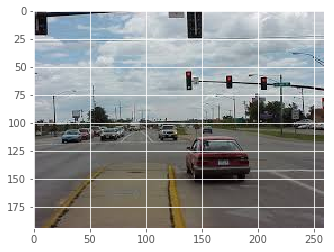

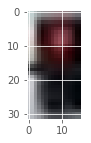

In [211]:
take_ID = False # Visu image from dataset

if take_ID:
    # Visualize Image from dataset
    ID = 80
    img = images[ID]
    label = labels[ID]
    plt.imshow(img)
else:
    # Or load something else
    path = "images/image009.jpg"
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,4))
    plt.imshow(img)
    # Detect traffic light in image
    with tf.Session(graph=detection_graph) as sess:
        coords = detect_tl(img)

    # Show detected traffic light only
    img = cv2.resize(img[coords[0]:coords[2], coords[1]:coords[3]], (16,32))
    plt.figure(figsize=(2, 2))
    plt.imshow(img)


image_np = np.expand_dims(np.asarray(img, dtype=np.uint8), 0)
pred_label = np.argmax(seq_model.predict(image_np)[0])
"Pred: ",pred_label, "True: ", label, " [0: rot, 1: gelb, 2: grün]"

## Timing Detection

The model zoo comes with a variety of models, each its benefits and costs. Below you'll time some of these models. The general tradeoff being sacrificing model accuracy for seconds per frame (SPF).

In [ ]:
def time_detection(sess, img_height, img_width, runs=10):
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')

    # warmup
    gen_image = np.uint8(np.random.randn(1, img_height, img_width, 3))
    sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: gen_image})
    
    times = np.zeros(runs)
    for i in range(runs):
        t0 = time.time()
        sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: image_np})
        t1 = time.time()
        times[i] = (t1 - t0) * 1000
    return times

In [ ]:
with tf.Session(graph=detection_graph) as sess:
    times = time_detection(sess, 600, 1000, runs=10)

In [ ]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
plt.title("Object Detection Timings")
plt.ylabel("Time (ms)")

# Create the boxplot
plt.style.use('fivethirtyeight')
bp = ax.boxplot(times)

### Exercise 4 - Model Tradeoffs

Download a few models from the [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) and compare the timings.

## Detection on a Video

Finally run your pipeline on [this short video](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/advanced_deep_learning/driving.mp4).

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('driving.mp4'))

### Exercise 5 - Object Detection on a Video

Run an object detection pipeline on the above clip.

In [ ]:
clip = VideoFileClip('driving.mp4')

In [ ]:
# The input is an NumPy array.
# The output should also be a NumPy array.
def pipeline(img):
    draw_img = Image.fromarray(img)
    boxes, scores, classes = sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: np.expand_dims(img, 0)})
    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.8
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = draw_img.size
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(draw_img, box_coords, classes)
    return np.array(draw_img)

**[Sample solution](./exercise-solutions/e5.py)**

In [ ]:
with tf.Session(graph=detection_graph) as sess:
    image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
    detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')
    
    new_clip = clip.fl_image(pipeline)
    
    # write to file
    new_clip.write_videofile('result.mp4')

In [ ]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('result.mp4'))

## Further Exploration

Some ideas to take things further:

* Finetune the model on a new dataset more relevant to autonomous vehicles. Instead of loading the frozen inference graph you'll load the checkpoint.
* Optimize the model and get the FPS as low as possible.
* Build your own detector. There are several base model pretrained on ImageNet you can choose from. [Keras](https://keras.io/applications/) is probably the quickest way to get setup in this regard.
